In [360]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [361]:
def embed_time_series(data, window_size):
    # function to form a hankel matrix from delay-embeddings from time series
    # data                  -   a snippet/observation window from a 1d time series
    # window_size           -   window_size in samples
    N = len(data)
    K = N - window_size+1
    hankel_matrix = np.zeros((window_size, K))
    for i in range(K):
        hankel_matrix[:, i] = data[i:i+window_size]
    return hankel_matrix

In [362]:
def decompose_hankel_matrix(hankel):
    U, S, Vt = np.linalg.svd(hankel,full_matrices=False)
    return U, S, Vt


In [363]:
def mean_anti_diagonals(A):
    # Get the dimensions of the matrix A
    rows, cols = A.shape
    #print(rows)
    #print(cols)
    # Initialize a list to store the anti-diagonal means
    anti_diagonal_means = []

    # Calculate the anti-diagonal means
    for k in range(1-rows, cols):
        anti_diagonal = np.diagonal(np.flipud(A), offset=k)
        anti_diagonal_means.append(np.mean(anti_diagonal))
    return np.array(anti_diagonal_means)

In [364]:
def reconstruct_time_series(U, S, Vt, selected_indices):
    reconstructed_matrix = np.zeros_like(U)
    for i in selected_indices:
        reconstructed_matrix += np.outer(U[:, i], S[i] * Vt[i, :])
    #print(reconstructed_matrix.shape)
    reconstructed_series = mean_anti_diagonals(reconstructed_matrix)
    #print(len(reconstructed_series))
    return reconstructed_series


In [365]:
# test reconstruct_time_series
#matrix1 = np.array([[1,1,1],[3,2,1],[1,1,1]])
#matrix2 = np.array([[1,3,1],[3,3,3],[1,1,1]])
#reconstruct_time_series(matrix1,np.arange(3), matrix2,[1])


In [366]:
def get_C_for_component_i(U1, U2,i):
    val = 0
    #print(U2.shape)
    for j in range(U2.shape[1]):
        temp = np.dot( U1[:,i], U2[:,j])
        #print(temp)
        if temp > val :
            val = temp
    return val

In [367]:
# test get_C_for_component_i
# matrix1 = np.array([[1,1,1],[2,2,2],[3,3,3]])
# matrix2 = np.array([[1,1,1],[1,1,1],[1,1,1]])
# val = get_C_for_component_i(matrix1, matrix2,0)


In [368]:
def component_selection(Ux, Uy, Uz, tau):
    indices = list()
    for i in range(Ux.shape[1]):
        # here we have to decide which direction we consider "main axis"
        C_xy = get_C_for_component_i(Ux, Uy, i)
        C_xz = get_C_for_component_i(Ux, Uz, i)
        if max(C_xy,C_xz)<tau:
            indices.append(i)
    return np.array(indices)

In [381]:
def do_ssa(time_series, observation_window, overlap, fs,tau):
    # perform singular spectrum analysis, based on singular value decomposition and 
    # thresholding for component selection, and return reconstructed signal that
    # should mainly include the "heart beating signal".
    
    # time_series                                  # 3-channel time-series (accelerometer data)
    window_size = observation_window * fs          # number of samples in window
    lagged_window_size = 201                       # window used for hankel matrix forming
    overlap_samples = overlap * fs                 # number of overlapping samples
    hr_prediction = np.zeros(int(np.floor((len(time_series)-window_size+1)/overlap_samples)))
    reconstructed_signal = np.zeros(time_series.shape[0])
    # loop over signal with overlap 
    series_length = time_series.shape[0]
    for i in range(0, len(time_series) - window_size + 1, overlap_samples):
        print(i/series_length)
        window_x = time_series[i:i + window_size,0]
        window_y = time_series[i:i + window_size,1]
        window_z = time_series[i:i + window_size,2]

        hankel_matrix_x = embed_time_series(window_x-np.mean(window_x), lagged_window_size)
        hankel_matrix_y = embed_time_series(window_y-np.mean(window_y), lagged_window_size)
        hankel_matrix_z = embed_time_series(window_z-np.mean(window_z), lagged_window_size)
        Ux, Sx, Vxt = decompose_hankel_matrix(hankel_matrix_x)
        Uy, Sy, Vyt = decompose_hankel_matrix(hankel_matrix_y)
        Uz, Sz, Vzt = decompose_hankel_matrix(hankel_matrix_z)

        plt.plot(Sx)
        plt.show()
        # condition used in the zhao paper 
        #selected_indices = component_selection(Ux,Uy,Uz,tau) # select primary axis here (first argument main axis)
        #print(selected_indices)
        
        # self chosen principal components
        selected_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
        reconstructed_series = reconstruct_time_series(Ux, Sx, Vxt, selected_indices) # here also select primary axis
        reconstructed_signal[i:i + window_size] = reconstructed_series
        # Now, 'reconstructed_series' contains the reconstructed time series based on SSA.

    return reconstructed_signal

In [370]:
# SET PATH HERE
path = "C:/Users/nicol/Desktop/ballistocardiography/data/data_apple/motion"
filenames = os.listdir(path)
file_numbers = list()

for name in filenames:
    file_numbers.append(name.replace("_acceleration.txt",""))

#print(file_numbers)


0.0
0.0


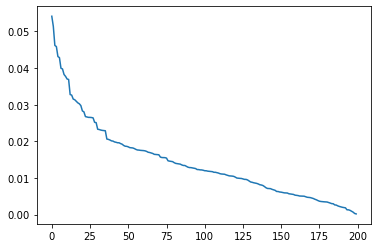

0.3


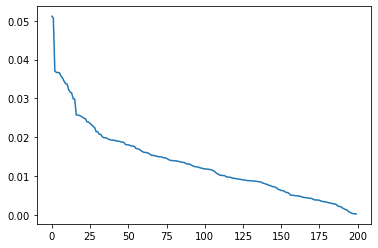

0.6


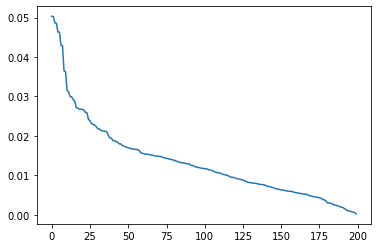

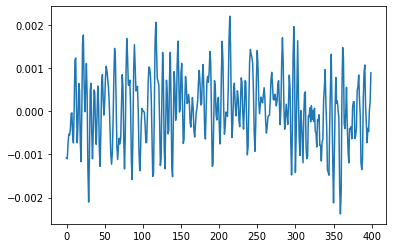

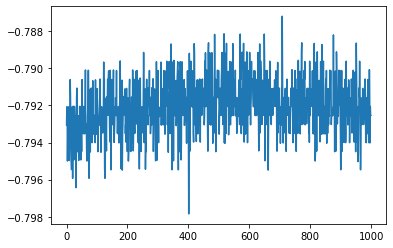

In [382]:
########### READ APPLE DATASET, PPG & ACCELEROMETER DATA ##############
# loop over files, read and divide into processable data

progress =-1
num_files = len(file_numbers)
for file_number in file_numbers:
    progress=progress+1
    input() ###### keep this if you want to stop at each step in the for loop (e.g. to look at some output)
    print(progress/num_files)
    hr = pd.read_csv("data/data_apple/heart_rate/"+file_number+ "_heartrate.txt").to_numpy()
    acc = pd.read_csv("data/data_apple/motion/"+file_number+ "_acceleration.txt", delimiter=' ').to_numpy()

    # get rid of all the data before the ppg actually starts recording as we dont have accurate labels there
    pos_time = hr[:,0]>0
    
    measured_ = hr[pos_time,0]
    heart_rate_ = hr[pos_time,1]

    # here i make sure that time is always increasing, and cut the window if it doesnt
    copy_index = 0
    for i in range(measured_.size-2):
        if (measured_[copy_index+1]>measured_[copy_index]):
            copy_index= copy_index +1
        else:
            break
    measured = measured_[:copy_index] # time
    heart_rate = heart_rate_[:copy_index] # heart rate
    # print(measured.size)
    # print(measured_acc.size
    
    # plt.plot(hr[:,1])
    # plt.show()
    # plt.plot(hr[:,0])
    # plt.show()
    # plt.plot(measured,heart_rate)
    # plt.show()
    # plt.plot(acc[:,0],acc[:,1])
    # plt.show()
    # plt.plot(measured_acc,x_acc)
    # plt.show()
    #plt.plot(measured_acc,magn)
    # plt.xlabel("time [sec]")
    # plt.ylabel("HR [bpm]")
    # plt.show()



    pos_time_acc = acc[:,0]>0
    measured_acc = acc[pos_time_acc,0] # timepoints accelerometer
    acceleration_signal = acc[pos_time_acc, 1:]
    x_acc = acc[pos_time_acc,1]
    y_acc = acc[pos_time_acc,2]
    z_acc = acc[pos_time_acc,3]

    x_acc2 = x_acc**2
    y_acc2 = y_acc**2
    z_acc2 = z_acc**2
    magn = np.sqrt(x_acc2 + y_acc2+ z_acc2)
    
    
    ##########################################
    ############# HERE GOES YOUR CODE ########
    ############## SSA #######################
    observation_window = 8                         # in seconds
    overlap = 6                                    # in seconds
    fs = 50                                        # in Hz 
    tau = 0.6                                  # threshold for component selection

    # call do_ssa
    #plt.plot(acceleration_signal)
    #plt.show()
    #stop = input("type until when analysis should be done:")
    #stop = 2000
    #plt.close()
    
    # choose some timepoints to look at some data
    t1 = 1000
    t2 = 2000
    hr_signal = do_ssa(acceleration_signal[t1:t2,:], observation_window, overlap, fs, tau)
    plt.plot(hr_signal[:400])
    plt.show()
    #plt.plot(magn)
    #plt.plot(magn[t1:t2]-np.mean(magn[t1:t2]))
    #plt.show()
    plt.plot(z_acc[t1:t2])
    plt.show()
    #plt.plot(z_acc[t1:t2]-np.mean(z_acc[t1:t2]))
    #plt.show()
    
    break

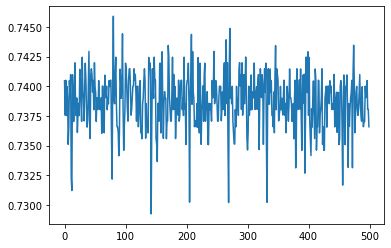

In [283]:
plt.plot(x_acc[2000:2500]-y_acc[2000:2500]-z_acc[2000:2500])

In [197]:
############## SSA, debugging #######################
# window_size = 8
# lag = 2
# fs = 50

# test_array = np.arange(1000)
# print(embed_time_series(test_array,window_size,lag,fs))